## Background

In the fastai course Part 1 [Lesson 6 video](https://youtu.be/AdhG64NF76E?feature=shared&t=3117) Jeremy Howard walked through the notebooks [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) and [Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) where he builds increasingly accurate solutions to the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) Kaggle Competition. In the video, Jeremy referenced a series of walkthrough videos that he made while working through the four-notebook series for this competition. I'm excited to watch these walkthroughs to better understand how to approach a Kaggle competition from the perspective of a former #1 Kaggle grandmaster.

In this blog post series, I'll walk through the code Jeremy shared in each of the 6 Live Coding videos focused on this competition, submitting predictions to Kaggle along the way. My last two blog posts in this series reference Jeremy's [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3) notebook to improve my large model ensemble predictions. Here are the links to each of the blog posts in this series:

- Part 1: Live Coding 8 (You are here)
- [Part 2: Live Coding 9](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-2/)
- [Part 3: Live Coding 10](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-3/)
- [Part 4: Live Coding 11](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-4/)
- [Part 5: Live Coding 12](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-5/)
- [Part 6: Live Coding 13](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-6/)
- [Part 7: Improving My Large Ensemble, Part 1](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-7/)
- [Part 8: Improving My Large Ensemble, Part 2](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-8/)


[Link to the Live Coding 8 video](https://www.youtube.com/watch?v=-Scs4gbwWXg)

## Setup

In [1]:
!pip install -qq timm==0.6.13
import timm
timm.__version__

'0.6.13'

You might have to restart kernel (right-click on a cell > scroll down and click "Restart Kernel") after installing a specific version of `timm`` to make sure Kaggle uses that version (and not the latest version which in January 2024 was 0.9.10).

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

In [4]:
trn_path = path/'train_images'

In [5]:
files = get_image_files(trn_path)

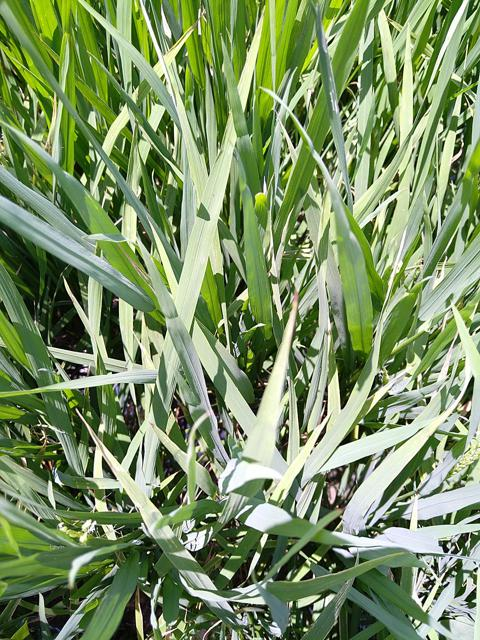

In [6]:
img = PILImage.create(files[0])
img

In [7]:
img.size

(480, 640)

## Get file sizes the slow way

In [8]:
%time sizes = [PILImage.create(o).size for o in files]

CPU times: user 30.1 s, sys: 1.76 s, total: 31.9 s
Wall time: 1min 59s


If most of the time is spent reading the image from the disk, doing it in parallel won't be much faster. If most of the time is spent decoding the JPEG, then doing it in parallel will be faster. Which of these is true depends on whether we are using an SSD.

#### Using parallel processing to speed things up

To do this in parallel (using the CPU):

In [9]:
from fastcore.parallel import *

In [10]:
def f(o): return PILImage.create(o).size

As you increase the number of workers (`n_workers`) from 2 to 4, the overall wall time decreases. When you increase from 4 to 8, it actually slightly increases.

In [11]:
%time sizes = parallel(f, files, n_workers=2)

CPU times: user 4.03 s, sys: 917 ms, total: 4.94 s
Wall time: 44.4 s


In [12]:
%time sizes = parallel(f, files, n_workers=4)

CPU times: user 3.78 s, sys: 689 ms, total: 4.47 s
Wall time: 29.8 s


In [13]:
%time sizes = parallel(f, files, n_workers=8)

CPU times: user 3.77 s, sys: 720 ms, total: 4.49 s
Wall time: 30.7 s


Note: you can't use `lambda` functions with `parallel`.

## Create a `DataLoaders` object

In [14]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    valid_pct=0.2,
    item_tfms=Resize(224)
)

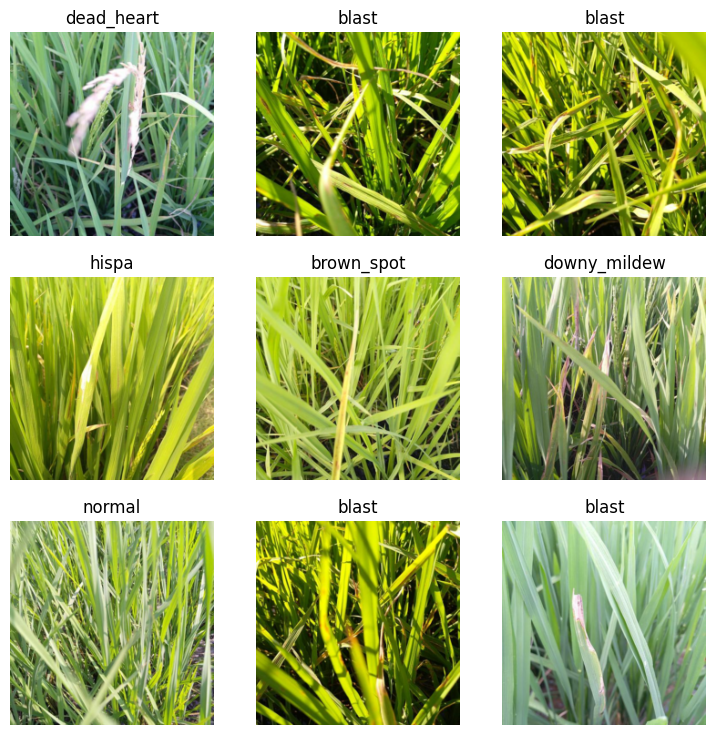

In [15]:
dls.show_batch()

```python
dls = ImageDataLoaders.from_folder(
  trn_path,
  valid_pct=0.2,
  item_tfms=Resize(224))
```

## Selecting a different image model from timm

View which models are available in the `timm` library:

In [16]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In `'convnext_small_in22k'`, `in` refers to ImageNet, `22k` refers to the version of ImageNet with 22,000 categories, which is more likely to have seen something like rice paddy images than the 1000 category version of ImageNet.

## Start fine tuning model

In [17]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


In [18]:
learn.fine_tune(2)

What does `fine_tune` do?
- Calls `Learner.freeze` which only allows the optimizer to change the last layer's weights
- Calls `Learner.fit_one_cycle` which updates the weights in the last layer for `freeze_epochs`
- Calls `Learner.unfreeze` to allow the optimizer to update all weights
- Calls `Learner.fit_one_cycle` for `epochs` which updates all of the layers' weights

If you are using a GPU that was released in the last 4 years or so (since 2019ish) it will train faster if you use half precision point. Most of the time on Colab or Kaggle you are not going to get one of those more up to date GPUs. Having said that, there's really never any harm using half-precision floating point. Even if you are using an older GPU, it's still going to save memory. To ask fastai to do that for you, add `.to_fp16()` at the end of the `vision_learner` call:

```python
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()
```

In [19]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(2)

Using `to_fp16` resulted in a training that took only about a third of the time as the full-precision training and actually resulted in a slightly better error rate. To be fair, the first time I ran both trainings, the half-precision training resulted in a slightly worse error rate.

## Discussion of `fit_one_cycle`

`fit_one_cycle` uses a scheduler which is something that changes the learning rate during training. Remember that the learning rate is the thing we multiply the gradients by before we subtract them from the parameters. When you have a randomly initialized model, or even a pretrained model (we randomly initialize the last layer of weights). At first even a pretrained model that we are fine-tuning can't do anything. It's still giving random answers. That means we want to use a really small learning rate because it's very difficult to get to a point where it's starting to learn something slightly useful. So with `fit_one_cycle` when we start training the first few batches use a tiny learning rate, and then as the model gets better and better at doing something useful, you can increase the learning rate because it's gotten to a point where it knows vaguely what it's doing. So as it trains the learning rate goes up, and then as you start to get close to the answer, you need to decrease the learning rate because you only need to take really little steps. The schedule used by `fit_one_cycle` is not interacting with anything (training loss, validation loss, etc) it's just following the shape of the curve of learning rate vs. batch number.

Sylvain Gugger has a good [blog post](https://sgugger.github.io/the-1cycle-policy.html) about the 1cycle policy.

The learning rate finder (`Learner.lr_find`) does something very similar to the 1cycle scheduler, which is that it gradually increases the learning rate while it train up to 100 batches, which is generally far less than an epoch. It doesn't increase then decrease the learning rate like `fit_one_cycle`, it just increases it until the whole training falls apart. Once the learning gets too high, the model jumps past the answer and the loss shoots off exponentially.

It surprisingly difficult to come up with algorithmically what our eyes do when we look at the loss curve to pick the best learning rate. Zach Mueller did a lot of experimenting with learning rate finder on the suggested learning rate defaults (minimum, steep, valley, slide). Note: "minimum" is the actual minimum divided by 10.

Most of the time fastai's default learning rate works fine. Particularly for a tabular dataset the learning rate can be almost anything. It really does depend on the model. If you try something and it doesn't seem to be training well, run `lr_rind` just in case the default learning rate is nowhere near the recommended values.

## Applying fine tuned model to test set

Now that we have a model, we'll have to apply it to our test set in order to submit it to Kaggle.

A test `DataLoader` is used for inference of a bunch of things at once.

In [20]:
tst_files = get_image_files(path/'test_images')

In [21]:
tst_files.sort()

In [22]:
tst_files

(#3469) [Path('../input/paddy-disease-classification/test_images/200001.jpg'),Path('../input/paddy-disease-classification/test_images/200002.jpg'),Path('../input/paddy-disease-classification/test_images/200003.jpg'),Path('../input/paddy-disease-classification/test_images/200004.jpg'),Path('../input/paddy-disease-classification/test_images/200005.jpg'),Path('../input/paddy-disease-classification/test_images/200006.jpg'),Path('../input/paddy-disease-classification/test_images/200007.jpg'),Path('../input/paddy-disease-classification/test_images/200008.jpg'),Path('../input/paddy-disease-classification/test_images/200009.jpg'),Path('../input/paddy-disease-classification/test_images/200010.jpg')...]

In [23]:
tst_dl = dls.test_dl(tst_files)

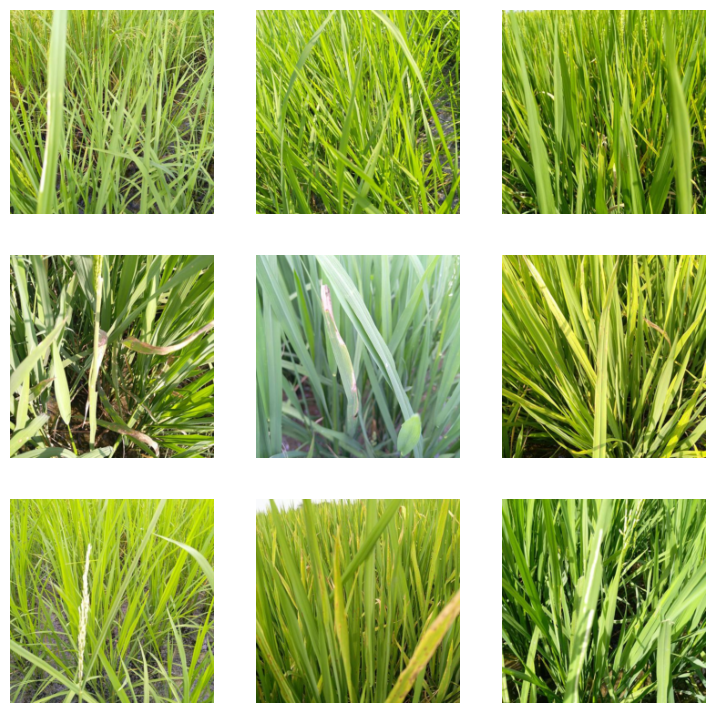

In [24]:
tst_dl.show_batch()

The key difference of a `test_dl` is that it doesn't have labels. 

## Applying fine tuned model to test set

Let's look at the sample submission provided in the Kaggle competition:

In [25]:
ss = pd.read_csv(path/'sample_submission.csv')

In [26]:
ss

image_id  label
0     200001.jpg    NaN
1     200002.jpg    NaN
2     200003.jpg    NaN
3     200004.jpg    NaN
4     200005.jpg    NaN
...          ...    ...
3464  203465.jpg    NaN
3465  203466.jpg    NaN
3466  203467.jpg    NaN
3467  203468.jpg    NaN
3468  203469.jpg    NaN

[3469 rows x 2 columns]

Unfortunately this doesn't help, but we know from the Kaggle competition page that they want the text of the classification in the `label` column.

In [27]:
preds = learn.get_preds(dl=tst_dl, with_decoded=True)

In [28]:
preds

(tensor([[1.6281e-02, 1.7275e-04, 3.7474e-04,  ..., 9.6960e-01, 6.2574e-04,
          8.8058e-05],
         [1.4577e-05, 1.6399e-04, 1.4309e-05,  ..., 4.8571e-05, 9.9965e-01,
          1.9105e-05],
         [5.7042e-04, 2.4972e-03, 1.3404e-04,  ..., 3.4435e-03, 9.8561e-04,
          1.1331e-04],
         ...,
         [2.4891e-03, 9.6513e-05, 3.8919e-05,  ..., 4.2361e-04, 9.9636e-01,
          2.4615e-04],
         [1.1240e-03, 5.4271e-01, 2.8814e-03,  ..., 2.3160e-01, 5.7650e-02,
          7.0772e-02],
         [1.6173e-11, 5.5747e-10, 1.5082e-08,  ..., 3.0132e-10, 6.3914e-10,
          3.0830e-07]]),
 None,
 tensor([7, 8, 3,  ..., 8, 1, 5]))

In [29]:
probs,_,idxs = preds

In [30]:
idxs

tensor([7, 8, 3,  ..., 8, 1, 5])

`idxs` are indexes into the `vocab` of the `DataLoaders`.

In [31]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

Convert `idxs` into a `Series` object so we can map it to the `vocab`:

In [32]:
idxs = pd.Series(idxs.numpy(), name="idxs")

In [33]:
idxs

0       7
1       8
2       3
3       3
4       3
       ..
3464    5
3465    7
3466    8
3467    1
3468    5
Name: idxs, Length: 3469, dtype: int64

We need to create a dictionary from `dls.vocab` that we can use as a mapping in `idxs.map`

In [34]:
mapping = {k: v for k,v in enumerate(dls.vocab)}

In [35]:
results = idxs.map(mapping)

Note: using a function for `Series.map` is really slow (259 times slower than using a dictionary).

In [36]:
%time idxs.map(mapping)

CPU times: user 784 µs, sys: 0 ns, total: 784 µs
Wall time: 666 µs


0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [37]:
%time idxs.map(lambda i: dls.vocab[i])

CPU times: user 241 ms, sys: 2.5 ms, total: 243 ms
Wall time: 243 ms


0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [38]:
ss['label'] = results

In [39]:
ss

image_id                  label
0     200001.jpg                  hispa
1     200002.jpg                 normal
2     200003.jpg                  blast
3     200004.jpg                  blast
4     200005.jpg                  blast
...          ...                    ...
3464  203465.jpg             dead_heart
3465  203466.jpg                  hispa
3466  203467.jpg                 normal
3467  203468.jpg  bacterial_leaf_streak
3468  203469.jpg             dead_heart

[3469 rows x 2 columns]

Normally at this point you should visually check your results:

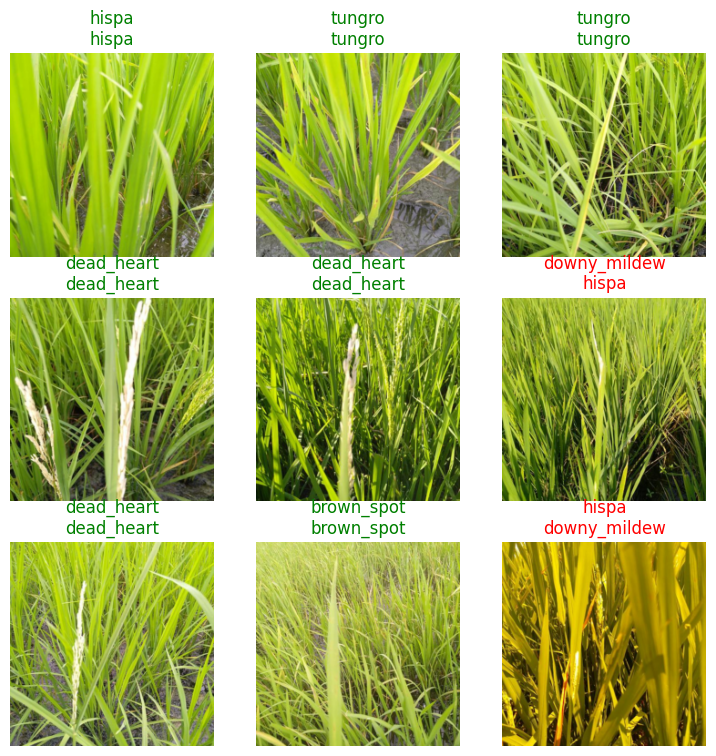

In [40]:
learn.show_results()

In this case, the problem is that I don't which one of these are right so I don't know what to look for.

In [41]:
ss.to_csv('submission.csv', index=False)

In [42]:
!head submission.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In my [next blog post](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-2/) I walk through the discussion and code from Live Coding 9.